# Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import glob
# from time import strptime
import datetime
import time
import copy

import neuralnetwork as nn
import mlutilities as ml
import dataloader as dl

from IPython.display import display
from ipywidgets import FloatProgress
from metpy.plots import SkewT

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
vol = '/Users/stock/Development/research/soundings/data/subset/'

In [3]:
def add_input(D, inputs, key):
    x_cord, y_cord = dl.lat_lon_point(D, inputs['lat'], inputs['lon'])
    try:
        inputs[key] = D['data'][x_cord][y_cord]
    except:
        print(f'ERROR! Unable to extract value from {f}')
        
def error_msg(model, inputs):
    print(f'ERROR! Unable to get {model} data for sounding. '
          f"{inputs['date']}, {inputs['lat']}, {inputs['lon']}")

In [4]:
fin = vol + '/radiosonde/20190912.dat'
radiosondes = dl.read_sonde(fin)

interval = 5
ret = None

for i in range(len(radiosondes)):
    
    y = []
    x = []
    
    ## extract SOUNDINGS
    sonde = pd.DataFrame(radiosondes[i]['data']).values
    # interpolate sounding values 
    for j in range(len(sonde) - 1):
        # pressure, temperature, dewpoint
        p1, t1, td1 = sonde[j][1], sonde[j][3], sonde[j][4]
        p2, t2, td2 = sonde[j+1][1], sonde[j+1][3], sonde[j+1][4]
        if p1 == p2:
            continue
        # temperature slope
        mt = (t1-t2)/(p1-p2)
        bt = -mt*p1 + t1
        # dewpoint slope
        mtd = (td1-td2)/(p1-p2)
        btd = -mtd*p1 + td1
        # add new values within interval
        for p in np.arange(p1, p2, -1):
            if p % interval == 0:
                t = mt*p + bt
                td = mtd*p + btd
                y.append({'P_r': p, 'T_r': t, 'Td_r': td})
    
    sonde_meta = radiosondes[i]['metadata']
    date = datetime.datetime(int(sonde_meta['YEAR']), time.strptime(sonde_meta['MONTH'],'%b').tm_mon, 
                             int(sonde_meta['DAY']), int(sonde_meta['HOUR']), tzinfo=datetime.timezone.utc)
    inputs = {}
    inputs['lat'], inputs['lon'] = sonde_meta['LAT'], sonde_meta['LON']
    inputs['date'] = date
    t0 = time.time()
    
    ## extract GOES
    files = sorted(glob.glob(vol + 'goes/' + date.strftime('*%Y%j%H*')))
    if len(files) != 8:
        error_msg('GOES', inputs)
        continue
    for f in files:
        D = dl.read_goes(f)
        add_input(D, inputs, 'G'+str(D['band_id'][0]))
    print(f'GOES took {time.time()-t0}')
    t0 = time.time()
    
    ## extract RTMA
    indicies = {'Pressure': 'P_s', 'Temperature': 'T_s', 'Dew point temperature': 'Td_s'}
    directories = glob.glob(vol + 'rtma/' + date.strftime('*%Y%m%d*/'))
    valid = True
    if len(directories) != 3:
        valid = False
        
    for d in directories:
        files = glob.glob(d + '/' + date.strftime('*%Y%m%d%H*'))
        if len(files) == 0:
            valid = False
            break
        for f in files:
            D = dl.read_rtma(f)
            add_input(D, inputs, indicies[D['name']])
    if not valid:
        error_msg('RTMA', inputs)
        continue
    print(f'RTMA took {time.time()-t0}')
    t0 = time.time()
    
    ## extract NWP RAP
    files = glob.glob(vol + 'nwp_model/' + date.strftime('*rap_*%Y%m%d_%H*'))
    if len(files) == 0:
        error_msg('NWP', inputs)
        continue
    for f in files:
        Ds = dl.read_nwp(f)[::-1]
        x_cord, y_cord = dl.lat_lon_point(Ds[0], inputs['lat'], inputs['lon'])
        for j in range(len(Ds) - 1):
            # pressure, temperature
            p1, t1 = Ds[j]['level'], Ds[j]['data'][x_cord][y_cord]
            p2, t2 = Ds[j+1]['level'], Ds[j+1]['data'][x_cord][y_cord]
            if p1 == p2:
                continue
            # temperature slope
            mt = (t1-t2)/(p1-p2)
            bt = -mt*p1 + t1
            # add new values within interval
            for p in np.arange(p1, p2, -1):
                if p % interval == 0:
                    t = mt*p + bt
                    inputs['P_n'] = p
                    inputs['T_n'] = t -273.15
                    x.append(copy.copy(inputs))
    print(f'NWP took {time.time()-t0}')

    join = pd.DataFrame(x).join(pd.DataFrame(y).set_index('P_r'), on='P_n').dropna()
    if ret is None:
        ret = join
    else:
        ret.append(join)
        
    print(f'INFO! Appended sounding data for '
          f"{inputs['date']}, {inputs['lat']}, {inputs['lon']}")

ERROR! Unable to get GOES data for sounding. 2020-09-12 14:00:00+00:00, 32.5, -114.0
ERROR! Unable to get GOES data for sounding. 2019-09-12 16:00:00+00:00, 32.5, -114.0
ERROR! Unable to get GOES data for sounding. 2019-09-12 20:00:00+00:00, 32.5, -114.0
GOES took 7.44516921043396
RTMA took 1.682952880859375
NWP took 2.1017239093780518
INFO! Appended sounding data for 2019-09-12 19:00:00+00:00, 41.6, -90.57
ERROR! Unable to get GOES data for sounding. 2019-09-12 15:00:00+00:00, 28.48, -80.55


In [5]:
ret.head()

,lat,lon,date,G8,G9,G10,G11,G13,G14,G15,G16,P_s,T_s,Td_s,P_n,T_n,T_r,Td_r
3,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,985,30.051764,30.755556,21.644444
4,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,980,29.679932,29.200000,21.200000
5,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,975,29.308099,28.800000,21.081818
6,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,970,28.853162,28.400000,20.963636
7,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,965,28.398224,28.000000,20.845455


In [6]:
X = ret.iloc[:,3:16].values
T = ret.iloc[:,16:].values
X.shape, T.shape

((177, 13), (177, 2))

In [7]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, 0.80, shuffle=True)

FloatProgress(value=0.0, max=17.0)

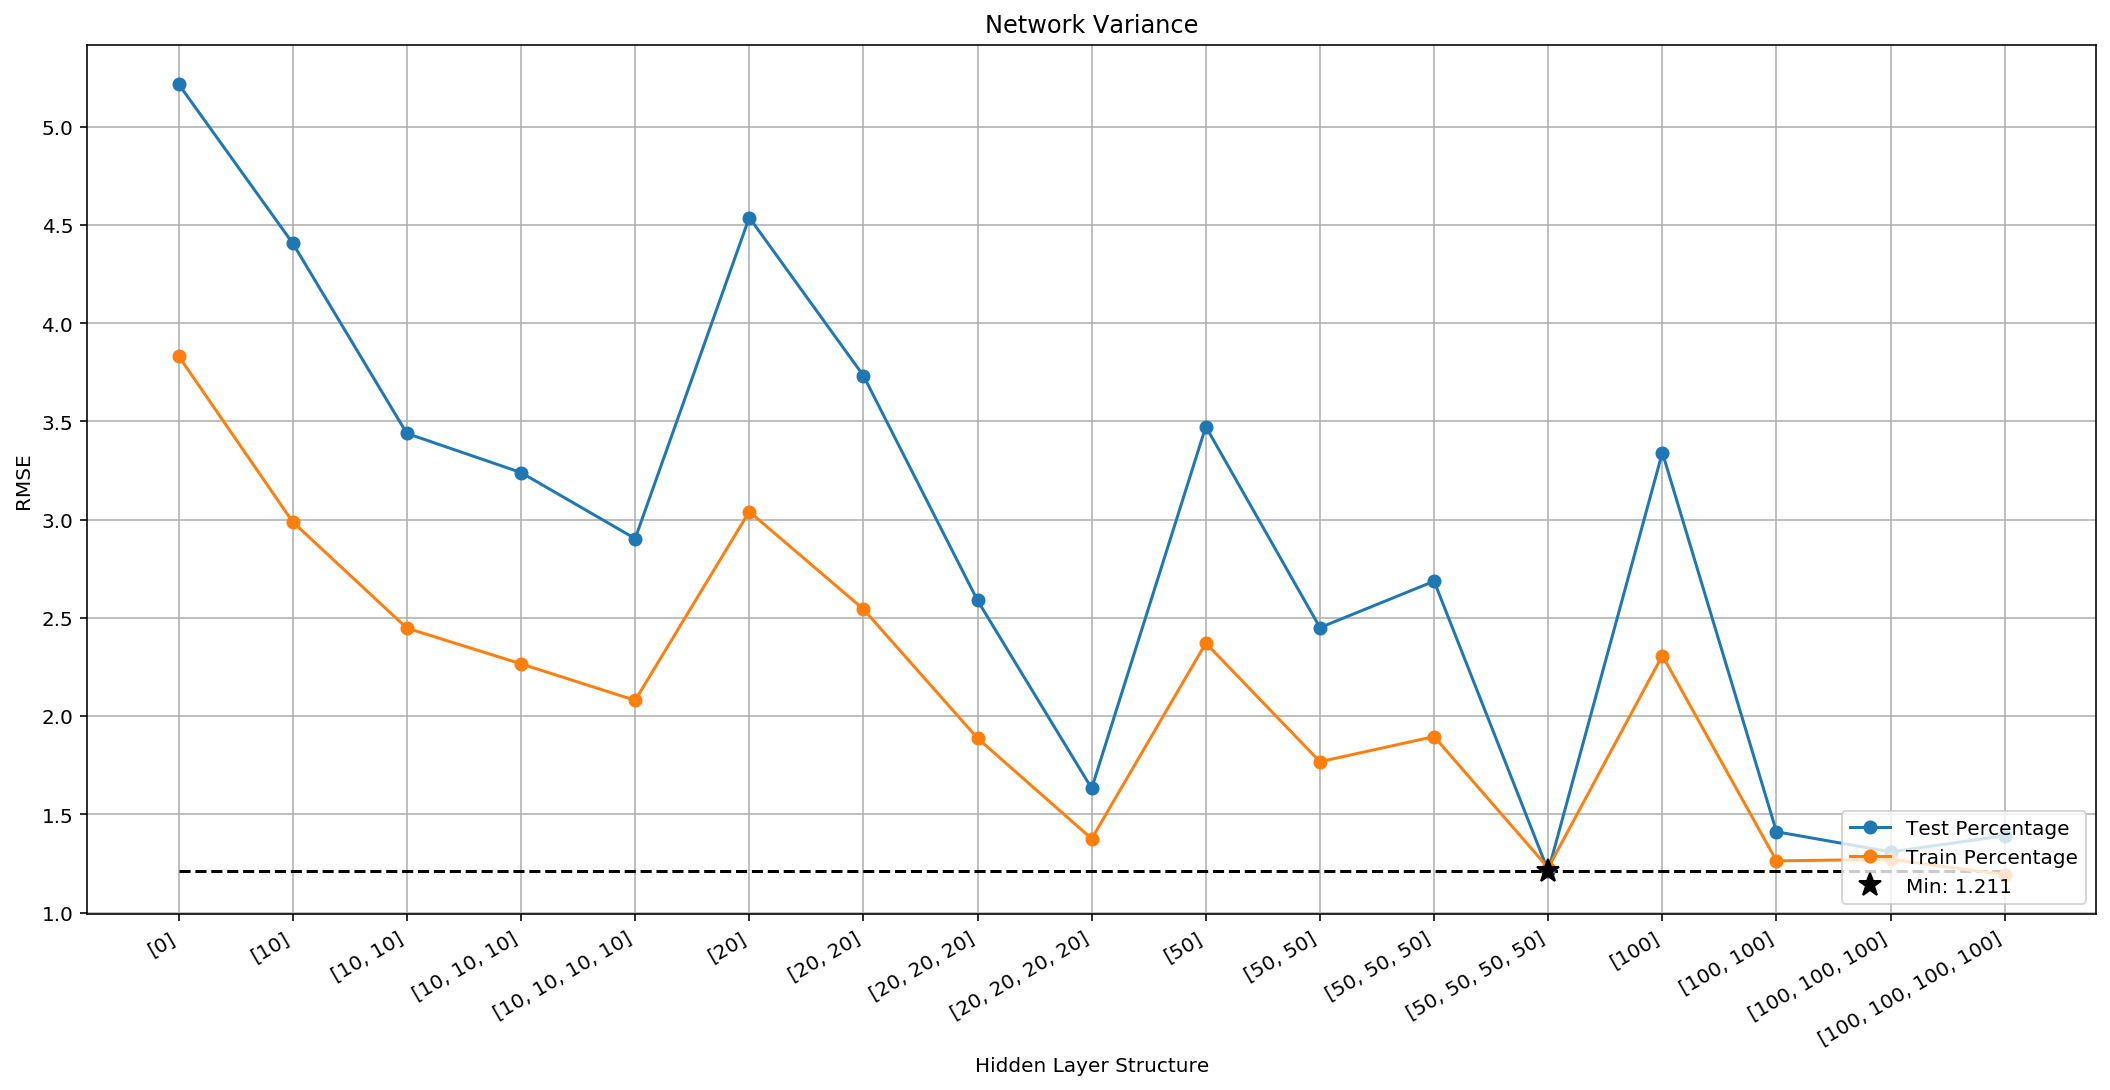

In [18]:
layers = [[0]] + [[nu] * nl for nu in [10, 20, 50, 100] for nl in range(1, 5)]

train_percentage = []
test_percentage = []
top = float('inf')

f = FloatProgress(min=0, max=len(layers))
display(f)
for layer in layers:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], layer, Ttrain.shape[1], activation='relu')
    nnet.train(Xtrain, Ttrain, 2000, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xtrain)
    train_percentage.append(ml.rmse(Ttrain, Y))
    
    Y = nnet.use(Xtest)
    temp = ml.rmse(Ttest, Y)
    test_percentage.append(temp)
    
    if temp < top:
        best_nnet = nnet
        top = temp
    
    f.value += 1
    
plt.figure(figsize=(18, 8))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(layers) - 1, linestyle='dashed')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(layers)), layers, rotation=30, horizontalalignment='right')

plt.legend(('Test Percentage', 'Train Percentage', 'Min: {:.3f}'.format(top)), loc=4)
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

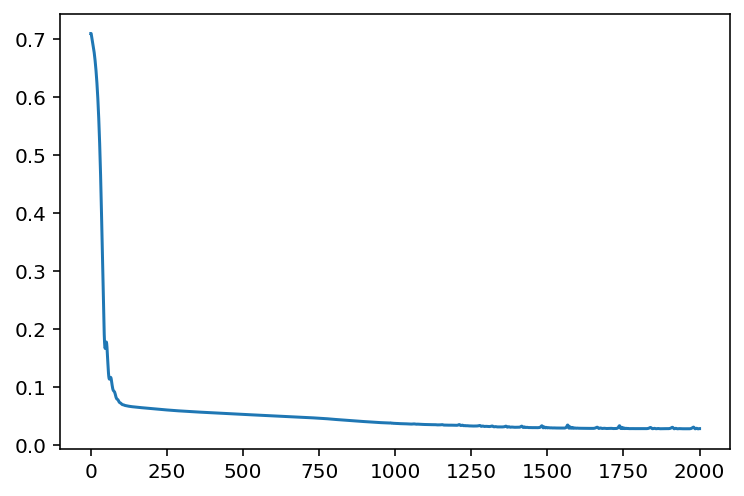

In [19]:
plt.plot(best_nnet.get_error_trace());

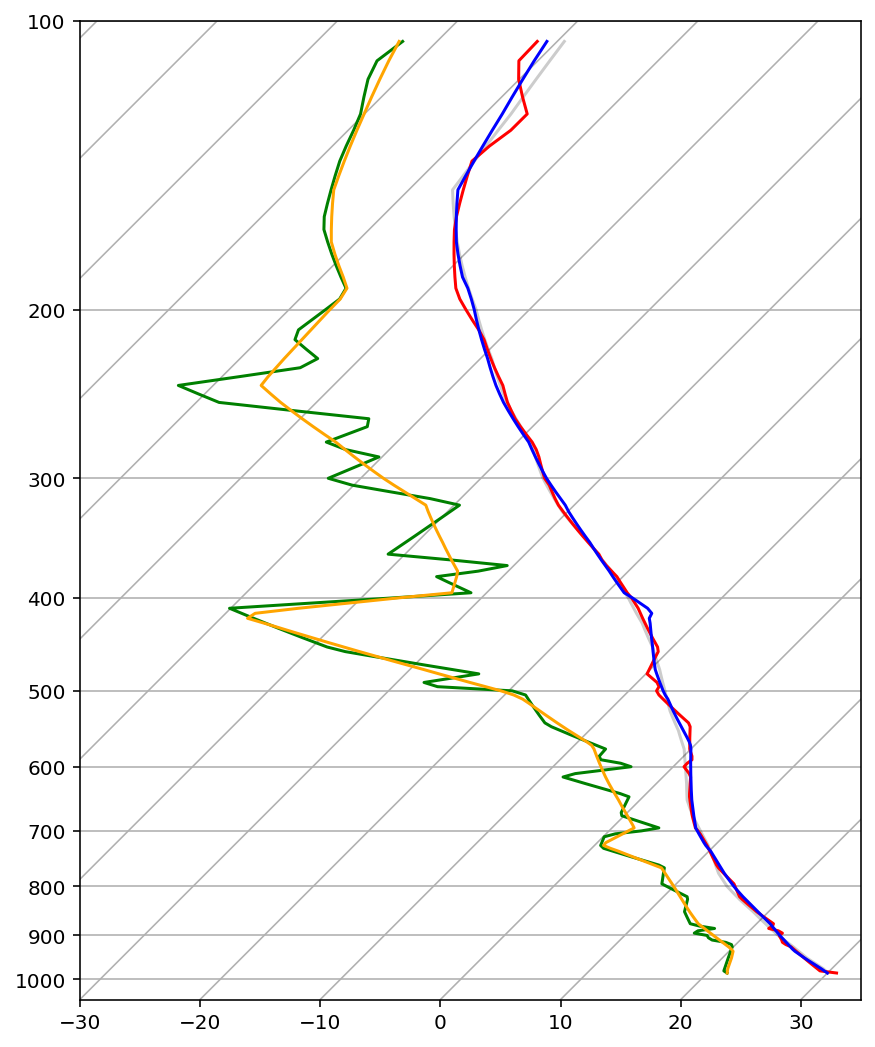

In [20]:
Y = best_nnet.use(X)

fig = plt.figure(figsize=(7, 9))
skew = SkewT(fig, rotation=45)
skew.plot(ret['P_n'], ret['T_n'], 'k', alpha=0.2);
skew.plot(ret['P_n'], ret['T_r'], 'r');
skew.plot(ret['P_n'], Y[:, 0], 'b');

skew.plot(ret['P_n'], ret['Td_r'], 'g');
skew.plot(ret['P_n'], Y[:, 1], 'orange');

skew.ax.set_xlim(-30, 35);

$
\begin{align}
X_n  & \\
& G_8 : \text{upper-level water vapor 6.2}\mu m \\
& G_9 : \text{mid-level water vapor 6.9}\mu m \\
& G_{10} : \text{lower-level water vapor 7.3}\mu m \\
& G_{11} : \text{cloud-top phase 8.4}\mu m \\
& G_{13} : \text{clean longwave window 10.3}\mu m \\
& G_{14} : \text{longwave window 11.2}\mu m \\
& G_{15} : \text{dirty longwave window 12.3}\mu m \\
& G_{16} : \text{CO2 longwave 13.3}\mu m \\
& P^s : \text{RTMA Surface Pressure} \\
& T^s : \text{RTMA Surface Temperature} \\
& T_d^s : \text{RTMA Surface Dew Point} \\
& P^n : \text{NWP Pressure, 25 mb increments} \\
& T^n : \text{NWP Temperature} \\
& T_d^n : \text{NWP Dew Point} \\
Y_n  & \\
& T^r : \text{Radiosonde Temperature} \\
& T_d^r : \text{Radiosonde Dew Point} 
\end{align}
$

| date          | lat  | lon | $G_n$ | $P^s$ | $T^s$ | $T_d^s$ | $P^n$ | $T^n$ | $T_d^n$ | ---- | $T^r$ | $T_d^r$ |
|:-------------:| :--: |:--: | :--:  | :--:  | :--:  | :--:    | :--:  | :---: | :--:    | ---- | :--:  | :--:    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 1000  | 31.2  | 22.2    | ---- | 31.6  | 21.9    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 975   | 31.5  | 21.9    | ---- | 31.2  | 21.4    |
...


| date          | lat  | lon | $G_n$ | $P^s$ | $T^s$ | $T_d^s$ | $T_{1000}^n$ | $T_{d1000}^n$ | $T_{995}^n$ | $T_{d995}^n$ | ... | ---- | $T_{1000}^r$ | $T_{d1000}^r$ | $T_{995}^r$ | $T_{d995}^r$ | ... |
|:-------------:| :--: |:--: | :--:  | :--:  | :--:  | :--:   | :---: | :--:     | :---: | :--:    | :--:  |  ---- | :--:  | :--:    | :--:  | :--:    | :--:    |
|2019-09-12-0300| 40.2 | -95.| ...   | 999   | 32.0  | 21.5    | 31.2  | 22.2     | 31.2  | 22.2    | ... | ---- | 31.6  | 21.9    | 31.6  | 21.9    | ... |